In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from datetime import datetime, timedelta

plt.style.use('ggplot')

In [5]:
# Путь до папки с данными
path_to_data = 'datasets/'

In [6]:
data = pd.read_csv(path_to_data + 'meteo/4403131.csv', ';', index_col = 'time')
data.columns

Index(['station_name', 'station_id', 'visibility_distance',
       'visibility_distance_quality', 'wind_direction',
       'wind_direction_quality', 'wind_speed_avg', 'wind_speed_avg_quality',
       'wind_speed_sign', 'wind_speed_max', 'wind_speed_max_quality',
       'wind_speed_max_sign', 'precipitation_amount',
       'precipitation_amount_quality', 'temperature_ground',
       'temperature_ground_quality', 'temperature_air',
       'temperature_air_quality', 'humidity', 'humidity_quality'],
      dtype='object')

In [8]:
data = data.sort_values(by=['station_id','time'])
data

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality
time,,,,,,,,,,,,,,,,,,,,
1987-02-01 00:00:00,POLTA26,4403131,83.0,0,230.0,0,4.0,0,NaN,8.0,0,NaN,NaN,5,-24.5,0,-18.1,0,46.0,0
1987-02-01 03:00:00,POLTA26,4403131,99.0,0,230.0,0,1.0,0,NaN,3.0,0,NaN,NaN,5,-24.0,0,-20.3,0,52.0,0
1987-02-01 06:00:00,POLTA26,4403131,99.0,0,280.0,0,2.0,0,NaN,5.0,0,NaN,NaN,5,-6.0,0,-10.7,0,42.0,0
1987-02-01 09:00:00,POLTA26,4403131,99.0,0,20.0,0,1.0,0,NaN,3.0,0,NaN,NaN,5,-6.0,0,-6.9,0,32.0,0
1987-02-01 12:00:00,POLTA26,4403131,99.0,0,110.0,0,3.0,0,NaN,8.0,0,NaN,NaN,5,-13.5,0,-9.7,0,44.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 09:00:00,POLTA26,4403131,NaN,5,280.0,0,2.0,0,NaN,7.0,0,NaN,NaN,5,-13.7,0,-10.5,0,31.0,0
2018-12-31 12:00:00,POLTA26,4403131,NaN,7,NaN,7,NaN,7,NaN,NaN,7,NaN,NaN,7,NaN,7,NaN,7,NaN,7
2018-12-31 15:00:00,POLTA26,4403131,NaN,5,0.0,0,0.0,0,NaN,3.0,0,NaN,NaN,5,-20.1,0,-17.1,0,60.0,0


Helpers

In [9]:
df = data.copy()

In [27]:
def nse(simulations, evaluation):
    nse = 1 - (np.sum((evaluation - simulations) ** 2, axis=0, dtype=np.float64)
        / np.sum((evaluation - np.mean(evaluation)) ** 2, dtype=np.float64))
    return nse

In [28]:
def na_heat_map(df, figsize=(20,12), cmap='viridis'):
    fig, ax = plt.subplots(figsize=figsize)
    sns_heatmap = sns.heatmap(df.isna(), yticklabels = False, cbar = False, cmap = cmap)

In [31]:
def interpolate_df(df, method = 'time', cols = []):
    if len(cols) == 0:
        return df.interpolate(method = method)
    else:
        res = df.copy()
        res[cols] =  res[cols].interpolate(method = method)
        return res

In [93]:
def plot_time_series(df, grouping_field, gf_vals, cols, start_date, end_date):
    _df = df.copy()
    if start_date != None and end_date != None:
        _df = _df.loc[start_date : end_date]
    elif start_date == None:
        _df = _df.loc[ : end_date]
    elif end_date == None:
        _df = _df.loc[start_date : ]
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10)) 
    print("KEK")
    for key, grp in _df[_df[grouping_field].isin(gf_vals)].loc[start_date:end_date].groupby(grouping_field): 
        for col in cols:
            ax.plot(grp.index, grp[col], label = key)

In [80]:
def plot_series(df, cols, start_date = None, end_date = None, figsize = (20,10), **plot_params):
    _df = df.copy()
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = figsize)
    if start_date != None and end_date != None:
        _df = _df.loc[start_date : end_date]
    elif start_date == None:
        _df = _df.loc[ : end_date]
    elif end_date == None:
        _df = _df.loc[start_date : ]
    
    for col in cols:
        ax.plot(_df.index, _df[col], *plot_params)

In [120]:
import statsmodels.api as sm
df

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality
time,,,,,,,,,,,,,,,,,,,,
1987-02-01 00:00:00,POLTA26,4403131,83.0,0,230.0,0,4.0,0,NaN,8.0,0,NaN,NaN,5,-24.5,0,-18.1,0,46.0,0
1987-02-01 03:00:00,POLTA26,4403131,99.0,0,230.0,0,1.0,0,NaN,3.0,0,NaN,NaN,5,-24.0,0,-20.3,0,52.0,0
1987-02-01 06:00:00,POLTA26,4403131,99.0,0,280.0,0,2.0,0,NaN,5.0,0,NaN,NaN,5,-6.0,0,-10.7,0,42.0,0
1987-02-01 09:00:00,POLTA26,4403131,99.0,0,20.0,0,1.0,0,NaN,3.0,0,NaN,NaN,5,-6.0,0,-6.9,0,32.0,0
1987-02-01 12:00:00,POLTA26,4403131,99.0,0,110.0,0,3.0,0,NaN,8.0,0,NaN,NaN,5,-13.5,0,-9.7,0,44.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 09:00:00,POLTA26,4403131,NaN,5,280.0,0,2.0,0,NaN,7.0,0,NaN,NaN,5,-13.7,0,-10.5,0,31.0,0
2018-12-31 12:00:00,POLTA26,4403131,NaN,7,NaN,7,NaN,7,NaN,NaN,7,NaN,NaN,7,NaN,7,NaN,7,NaN,7
2018-12-31 15:00:00,POLTA26,4403131,NaN,5,0.0,0,0.0,0,NaN,3.0,0,NaN,NaN,5,-20.1,0,-17.1,0,60.0,0


In [129]:
def extract_seasonality(series, period):
    return sm.tsa.seasonal_decompose(series, period = period).seasonal

def substract_seasonality(series, period):
    return series - sm.tsa.seasonal_decompose(series, period = period).seasonal

KEK


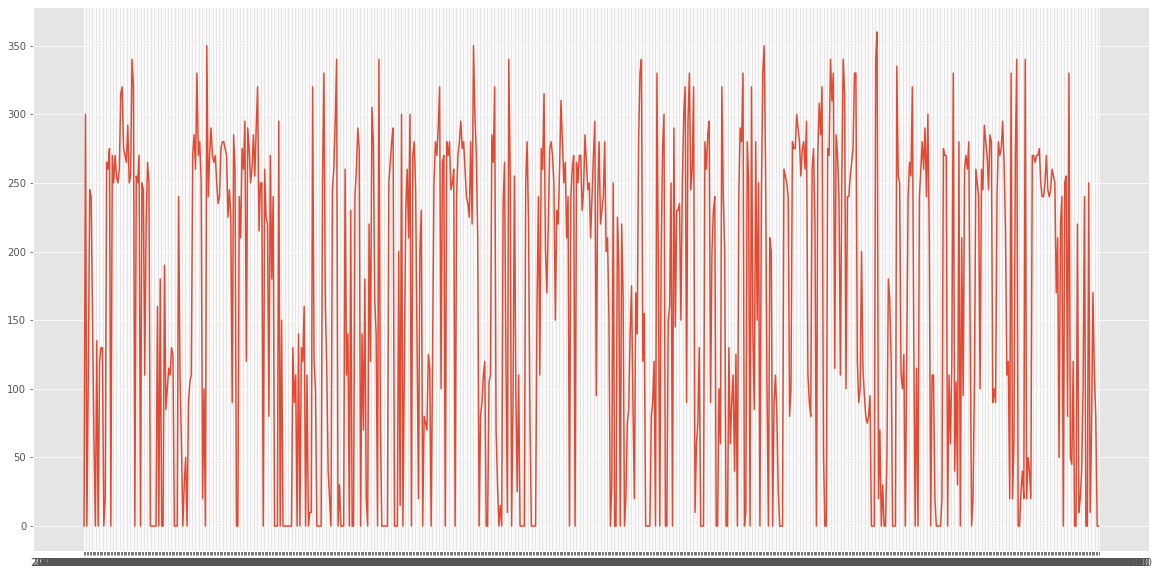

In [95]:
plot_time_series(df, 'station_id', ['4403131', '4403133'], ['wind_direction'], '2001-01-01', '2001-04-01')

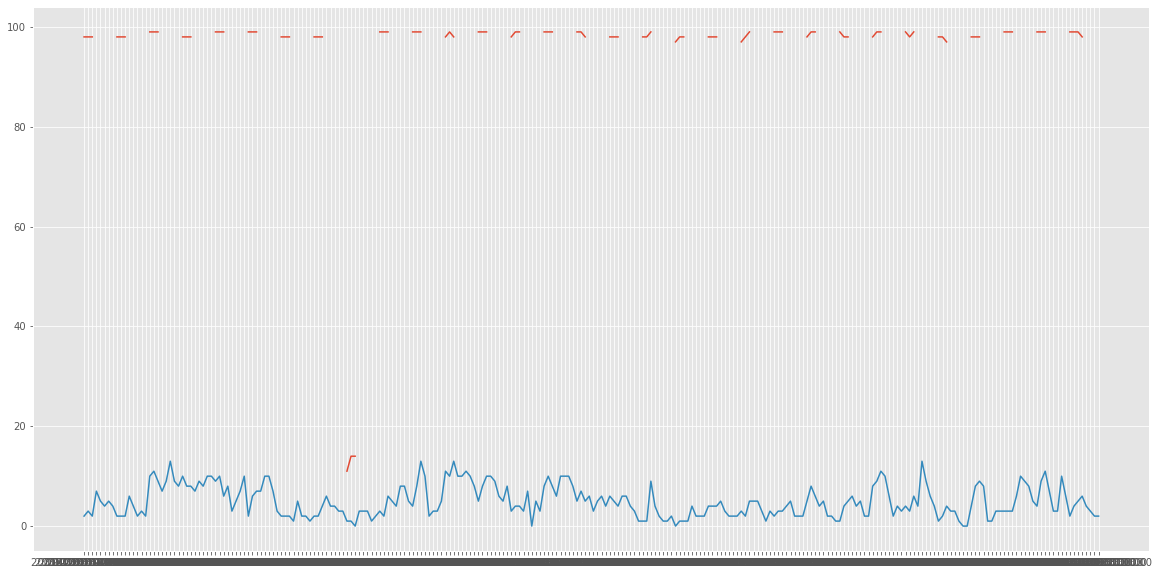

In [82]:
plot_series(df, ['visibility_distance', 'wind_speed_max'], '2001-01-01', '2001-02-01')

In [34]:
def get_acc_ice(data, year):
    return data['ice_thickness'][datetime(year=year - 1, month = 10, day = 1) : datetime(year=year, month = 5, day = 1)].sum()

def get_acc_snow(data, year):
    return data['snow_height'][datetime(year=year - 1, month = 10, day = 1) : datetime(year=year, month = 5, day = 1)].sum()

In [29]:
dd = pd.read_pickle(path_to_data + 'processed_data/disch_d.pkl')
dd.set_index('date')

,consumption,station_id
date,,
1984-01-01,1300.0,5013
1984-01-02,1310.0,5013
1984-01-03,1320.0,5013
1984-01-04,1330.0,5013
1984-01-05,1320.0,5013
...,...,...
NaT,NaN,6574
NaT,NaN,6574
NaT,NaN,6574


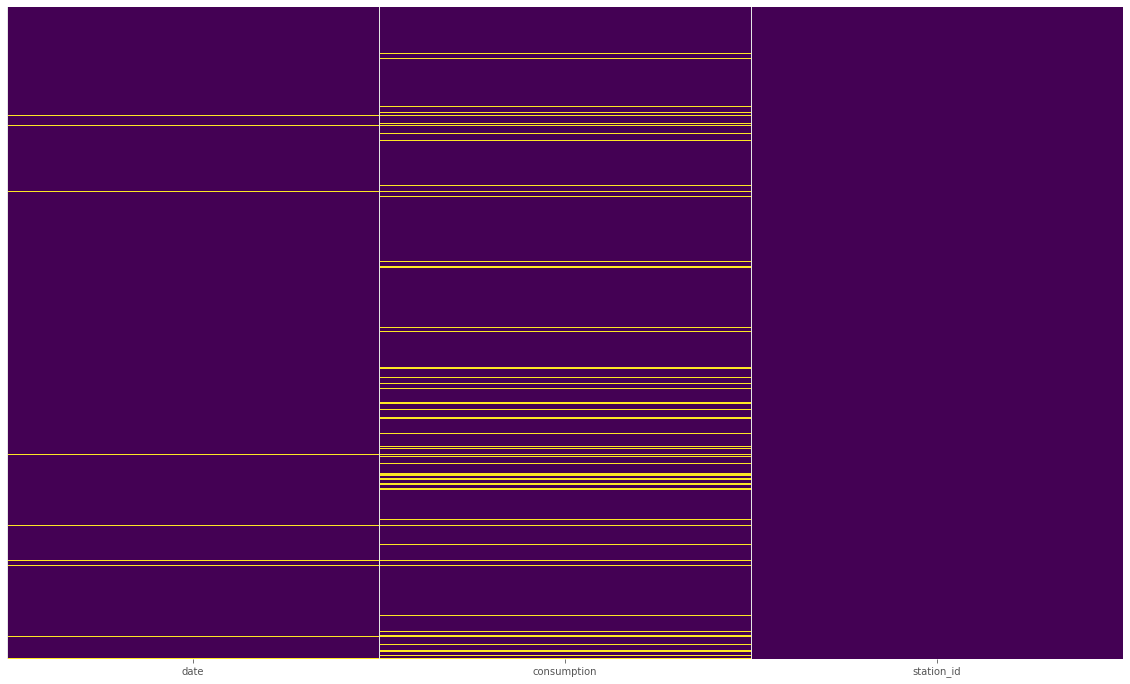

In [30]:
na_heat_map(dd)

<AxesSubplot:>

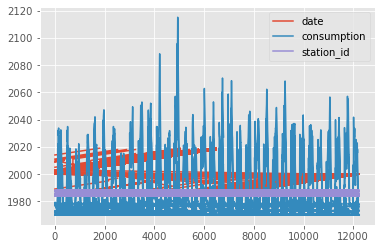

In [22]:
dd.plot()

In [50]:
df = pd.read_pickle(path_to_data + "processed_data/disch_d.pkl")
df

,date,consumption,station_id
6482,1984-01-01,1300.0,5013
6483,1984-01-02,1310.0,5013
6484,1984-01-03,1320.0,5013
6485,1984-01-04,1330.0,5013
6486,1984-01-05,1320.0,5013
...,...,...,...
5100,NaT,NaN,6574
5101,NaT,NaN,6574
5461,NaT,NaN,6574
5820,NaT,NaN,6574


In [51]:
def split_df_by(df, col):
    return df.groupby(col)

def helper_save(lst, path, name):
    for grp, df in lst:
        df.to_csv(path + '0' + str(grp) + name, index = 'date')

helper_save(split_df_by(df, 'station_id'), './data/hydro/', '_disch_d.csv')

In [78]:
df = pd.read_pickle(path_to_data + "processed_data/daily.pkl")
df 

,date,stage_avg,stage_min,stage_max,temp,water_code,station_id
6577,1984-01-01,258.0,258.0,258.0,NaN,NaN,5001
6578,1984-01-02,255.0,255.0,255.0,NaN,NaN,5001
6579,1984-01-03,252.0,252.0,252.0,NaN,NaN,5001
6580,1984-01-04,248.0,248.0,248.0,NaN,NaN,5001
6581,1984-01-05,244.0,244.0,244.0,NaN,NaN,5001
...,...,...,...,...,...,...,...
5628,2017-12-27,10.0,10.0,10.0,NaN,18.0,6574
5629,2017-12-28,10.0,10.0,10.0,NaN,18.0,6574
5630,2017-12-29,9.0,9.0,9.0,NaN,18.0,6574
5631,2017-12-30,9.0,9.0,9.0,NaN,18.0,6574


In [73]:
def get_meteo(station_id, data_path):
    x = pd.read_pickle(data_path + "processed_data/s2m.pkl")
    return pd.read_csv(data_path + 'meteo/' + str(int(x.loc[station_id]['meteo_id'])) + '.csv', sep = ';'), x.loc[station_id]['dist']

In [77]:
class RiverNodeModel:
    def __load__(self):
        self.hydro_df = pd.read_csv(self.data_path + 'hydro/0' + str(self.post_id) + '_daily.csv', sep=';', engine='python')
        self.ice_df = pd.read_csv(self.data_path + 'hydro/0' + str(self.post_id) + '_ice.csv', sep=';', engine='python')
        self.meteo_df = get_meteo(self.post_id, path_to_data)
        try:
            self.disch_df = pd.read_csv(self.data_path + 'hydro/0' + str(self.post_id) + '_disch_d.csv', sep=';', engine='python')
        except FileNotFoundError:
            self.disch_df = None
            
        dframes = [self.hydro_df, self.ice_df, self.meteo_df, self.disch_df]
        for df in dframes:
            print(df)
        
    def __init__(self, post_id, data_path):
        self.post_id = post_id
        self.data_path = data_path
        self.__load__()
    
RiverNodeModel(6523, './data/')

     ,date,stage_avg,stage_min,stage_max,temp,water_code,station_id
0          2,2000-10-01,136.0,136.0,136.0,9.5,29.0,6523            
1         3,2000-10-02,135.0,134.0,136.0,10.2,29.0,6523            
2          4,2000-10-03,133.0,133.0,133.0,8.2,29.0,6523            
3          5,2000-10-04,133.0,133.0,133.0,8.1,29.0,6523            
4          6,2000-10-05,132.0,132.0,132.0,6.4,29.0,6523            
...                                                 ...            
6296       6298,2017-12-27,144.0,144.0,144.0,,16.0,6523            
6297       6299,2017-12-28,144.0,144.0,144.0,,16.0,6523            
6298       6300,2017-12-29,144.0,144.0,144.0,,16.0,6523            
6299       6301,2017-12-30,144.0,144.0,144.0,,16.0,6523            
6300       6302,2017-12-31,144.0,144.0,144.0,,16.0,6523            

[6301 rows x 1 columns]
    ,date,ice_thickness,snow_height,place,station_id
0                              2,2000-10-15,,,1,6523
1                              3,2000-10-20,,,1,6523


In [81]:
class TimeSeriesExtracter():
    def __init__(self, id_col, x_cols, deltas, lags):
        self.id_col = id_col
        self.x_cols = x_cols
        self.deltas = deltas
        self.lags = lags
        pass
    
    def fit(self, df, **fit_params):
        self.df = df.copy()
        return self
    
    def transform(self, **transform_params):
        for x, d, lag, in zip(self.x_cols, self.deltas, self.lags):
            for i in range(d, d + lag):
                self.df[x + "_t_" + str(i)] = self.df.groupby(self.id_col)[x].shift(i)
                
        return self.df
    
    def fit_transform(self, df):
        return self.fit(df).transform()

In [82]:
TimeSeriesExtracter('station_id', ['temperature_ground'], [1], [3]).fit_transform(df)

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,...,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,temperature_ground_t_1,temperature_ground_t_2,temperature_ground_t_3
time,,,,,,,,,,,,,,,,,,,,,
1987-02-01 00:00:00,POLTA26,4403131,83.0,0,230.0,0,4.0,0,NaN,8.0,...,5,-24.5,0,-18.1,0,46.0,0,NaN,NaN,NaN
1987-02-01 03:00:00,POLTA26,4403131,99.0,0,230.0,0,1.0,0,NaN,3.0,...,5,-24.0,0,-20.3,0,52.0,0,-24.5,NaN,NaN
1987-02-01 06:00:00,POLTA26,4403131,99.0,0,280.0,0,2.0,0,NaN,5.0,...,5,-6.0,0,-10.7,0,42.0,0,-24.0,-24.5,NaN
1987-02-01 09:00:00,POLTA26,4403131,99.0,0,20.0,0,1.0,0,NaN,3.0,...,5,-6.0,0,-6.9,0,32.0,0,-6.0,-24.0,-24.5
1987-02-01 12:00:00,POLTA26,4403131,99.0,0,110.0,0,3.0,0,NaN,8.0,...,5,-13.5,0,-9.7,0,44.0,0,-6.0,-6.0,-24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 09:00:00,POLTA26,4403131,NaN,5,280.0,0,2.0,0,NaN,7.0,...,5,-13.7,0,-10.5,0,31.0,0,NaN,-1.4,NaN
2018-12-31 12:00:00,POLTA26,4403131,NaN,7,NaN,7,NaN,7,NaN,NaN,...,7,NaN,7,NaN,7,NaN,7,-13.7,NaN,-1.4
2018-12-31 15:00:00,POLTA26,4403131,NaN,5,0.0,0,0.0,0,NaN,3.0,...,5,-20.1,0,-17.1,0,60.0,0,NaN,-13.7,NaN


In [98]:
ice_data = pd.read_pickle(path_to_data + 'processed_data/ice.pkl')
ice_data = ice_data.set_index('date')
ice_data

,ice_thickness,snow_height,place,station_id
date,,,,
1984-11-30,41.0,NaN,1,5001
1984-12-05,40.0,NaN,1,5001
1984-12-10,50.0,NaN,1,5001
1984-12-15,56.0,NaN,1,5001
1984-12-20,62.0,NaN,1,5001
...,...,...,...,...
2017-12-10,18.0,NaN,1,6574
2017-12-15,19.0,6.0,1,6574
2017-12-20,24.0,7.0,1,6574


In [107]:
ice_df = ice_data[['ice_thickness', 'snow_height']]\
.shift(1)\
.resample('W')\
.agg({
    'ice_thickness': 'sum',
    'snow_height': 'sum'
})

In [108]:
ice_df['ice_thickness'].value_counts()

0.0        870
89.0         3
63.0         3
2007.0       2
780.0        2
          ... 
10663.0      1
6925.0       1
9859.0       1
4695.0       1
1500.0       1
Name: ice_thickness, Length: 918, dtype: int64